In [4]:
def armamle(X, theta0, p):
    theta, logl = steepdescent(X, theta0, p)
    q = len(theta0) - 2 - p
    T = len(X)
    alpha, beta = theta[:p], theta[p:p + q]
    sigma, c = theta[p + q], theta[p + q + 1]
    e = np.zeros(T)
    m = max(p, q)
    for j in range(m, T):
        e[j] = X[j] - c - np.dot(alpha, X[j - p:j][::-1]) - np.dot(beta, e[j - q:j][::-1])
    res = e
    logl = -logl
    #Function returns model parameters-theta, log-likelihood and residuals
    return theta, logl, res


def steepdescent(Xx, theta0, p0):
    itr = 200
    maxi = 20
    tol = 1.0e-8
    lmbda = 1.0e-3
    j = 0
    th = theta0
    #likelihood
    Fnc = lharma(th, Xx, p0)
    #Gradient of ARMA
    grad = garma(th, Xx, p0)
    
    while (np.linalg.norm(grad) >= tol) & (j < itr):
        step = -grad
        gstp = np.dot(grad.T, step)
        gama = min(1, 1 / np.linalg.norm(step))
        i = 1
        while (lharma(th + gama * step, Xx, p0)) > (Fnc + gama * lmbda * gstp):
            i += 1
            gama = gama / 2
            if i > maxi:
                break
        th = th + gama * step
        Fnc = lharma(th, Xx, p0)
        grad = garma(th, Xx, p0)
        j += 1
    return th, Fnc

#Calculates the negative log-likelihood
def lharma(theta0, X, p):
    
    #assigning values to varables
    q = len(theta0) - 2 - p
    T = len(X)
    #exctracting the parameters from theta0
    #and assigning them to alhpa, beta, sigma, c.
    alpha, beta = theta0[:p], theta0[p:p + q]
    sigma, c = theta0[p + q], theta0[p + q + 1]
    y = 0
    #initialised to array of zeros
    e = np.zeros(T)
    #maximum of AR and MA coeff.
    m = max(p, q)
    #for-loop to calculate the residuals at each time-step of j
    for j in range(m, T):
        e[j] = X[j] - c - np.dot(alpha, X[j - p:j][::-1]) - np.dot(beta, e[j - q:j][::-1])
        y += e[j] ** 2
    #normalised with the noise sigma
    y = y / (2 * sigma ** 2)
    #log-likelihood is calculated and returned
    y += np.log(sigma ** 2) * (T - m) / 2 + np.log(2 * np.pi) * (T - m) / 2
    return y

##Calculates the gradient of negative log-likelihood
def garma(theta0, X, p):
    h = 0.0001
    nw = len(theta0)
    gval = np.zeros(nw)
    for i in range(nw):
        xph = theta0.copy()
        xph[i] = theta0[i] + h
        fxph = lharma(xph, X, p)
        xmh = theta0.copy()
        xmh[i] = theta0[i] - h
        fxmh = lharma(xmh, X, p)
        gval[i] = (fxph - fxmh) / (2 * h)
    return gval

Value m=max(p,q) 2
The shape of X: (600,)
Model Estimates
[[0.9  0.25 0.5  1.   0.  ]]
[ 0.91339632  0.48356106 -0.08390014 -0.49420208  0.01994683]


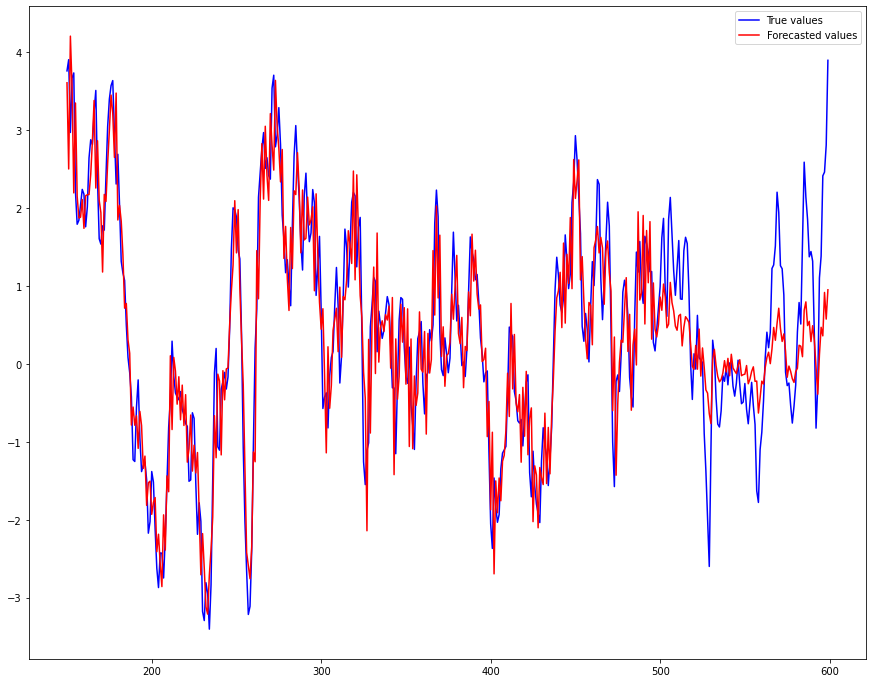

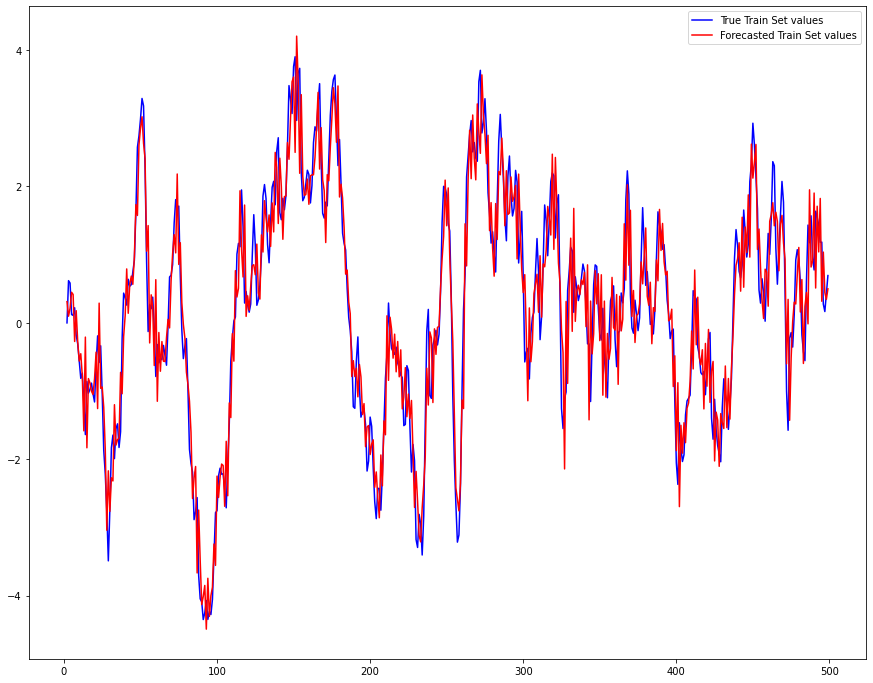

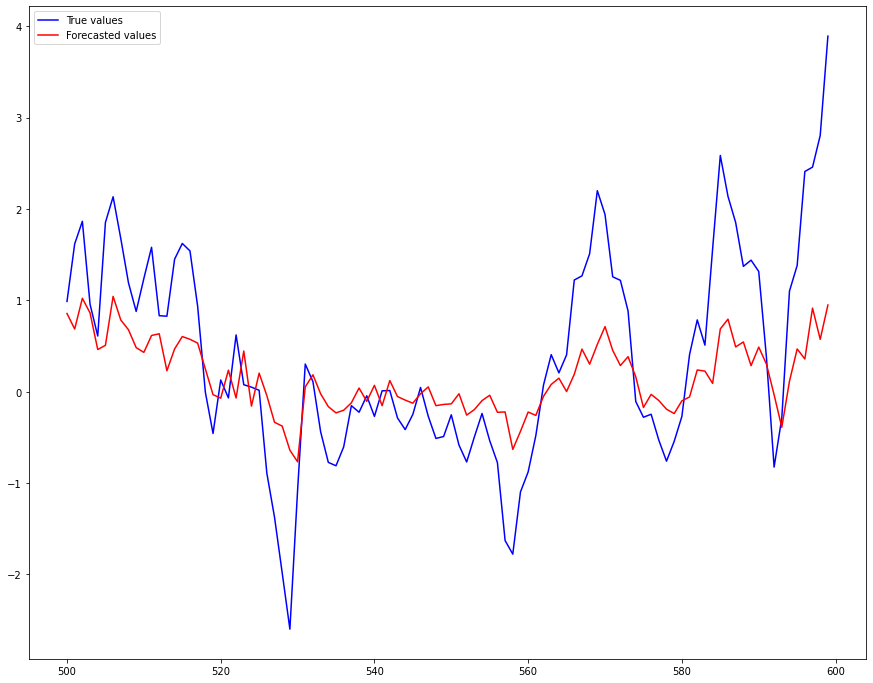

Mean Squared Error: 0.3859319885222938
sum Squared Error: 192.19413028410233


In [6]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt

#initialising variables
T = 500

# AR coefficients
a = np.array([0.9]) 

# MA coefficients
b = np.array([0.25, 0.5])
#noise
sigma = 1

#initialising variables
n = 100
X = np.zeros(n + T)
X[0] = 0

#Order of the AR & MA components for the model
p = len(a)
q = len(b)
m = max(p, q)
print("Value m=max(p,q)",m)

#variable decalaration for length of noise term
eVar = n + T + q

#random values - gaussian dsitribution
e = np.random.randn(eVar, 1)

#Loop to generate the ARMA time-series data 
#generated data is stored in X[]
for i in range(m + 1, T + n):
    X[i] = (a.T).dot(X[i - 1:i - p - 1:-1]) + (b.T).dot(e[i - 1:i - q - 1:-1])

#storing the time-series into an array
arma_time_series = np.array(X)

##save it into a csv file
np.savetxt("arma_time_series.csv", arma_time_series, delimiter=",")

print("The shape of X:",X.shape)

#initialising coefficients for ARMA model
theta0 = np.array([0.5, 0.4, 0.3, 0.8, 0.01]).T

#Calling the armamle function to estimate the model parameters
theta, logl, res = armamle(X[:T], theta0, p)

#joining several arrays including the AR & MA parameters into one array theta_true
theta_true = np.concatenate((a.reshape(-1,1), b.reshape(-1,1), np.array([[sigma]]), np.array([[0]])), axis=0).T

print("Model Estimates")
print(theta_true)
print(theta)


#assigning parameters from theta to alpha, beta, sigma
#and initialising c = 0
alpha = theta[:p]
beta = theta[p:p + q]
sigma = theta[p + q]
c = 0

#initialsing array y & er to zeros
y = np.zeros(T + n)
er = np.zeros(T + n)
e=e.ravel()
er[:T] = e[:T]

#looping over from m to T
#to run predictions for the arma model
for j in range(m, T):
    y[j] = c + (alpha.T).dot(X[j - p:j][::-1]) + (beta.T).dot(er[j - q:j][::-1])

#looping over from T to T+n
#to generate error and predictions for the arma model
for j in range(T, T + n):
    y[j] = c + (alpha.T).dot(y[j - p:j][::-1]) + (beta.T).dot(er[j - q:j][::-1])
    er[j] = X[j] - c - (alpha.T).dot(X[j - p:j][::-1]) - (beta.T).dot(er[j - q:j][::-1])

#plotting all the results 
plt.figure(figsize=(15,12))
plt.plot(range(150, T + n), X[150:T + n], 'b', label="True values")
plt.plot(range(150, T + n), y[150:T + n], 'r', label="Forecasted values")
plt.legend()
plt.show()

#plotting results for arma model for iteration m to T
plt.figure(figsize=(15,12))
plt.plot(range(m, T), X[m:T], 'b', label="True Train Set values")
plt.plot(range(m, T), y[m:T], 'r', label="Forecasted Train Set values")
plt.legend()
plt.show()

#plotting results for arma model for iteration T to T+n
plt.figure(figsize=(15,12))
plt.plot(range(T, T + n), X[T:T + n], 'b', label="True values")
plt.plot(range(T, T + n), y[T:T + n], 'r', label="Forecasted values")
plt.legend()
plt.show()

mse = np.mean((y[m:T] - X[m:T])**2)
print("Mean Squared Error:", mse)
sse = mse * (T - m)
print("sum Squared Error:", sse)
